In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

In [3]:
print("Initialisation...")
if tf.config.list_physical_devices('GPU'):
    print("GPU détecté.")
else:
    print("Aucun GPU détecté, l'entraînement se fera sur le CPU.")

Initialisation...
Aucun GPU détecté, l'entraînement se fera sur le CPU.


In [4]:
# Paramètres
img_size = 150
data_dir1 = '../../../chest_xray/train/PNEUMONIA'
data_dir2 = '../../../chest_xray/train/NORMAL'
batch_size = 16
epochs = 20
n_splits = 15

print("Paramètres définis.")

Paramètres définis.


In [10]:
# Prétraitement des Données
def load_data(data_dir1, data_dir2, limit=100):
    print("Chargement des données...")
    data = []
    labels = ['PNEUMONIA', 'NORMAL']
    for dir in [data_dir1, data_dir2]:
        path = os.path.join(dir)
        if not os.path.exists(path):
            print(f"Le répertoire {path} n'existe pas")
            continue
        label = os.path.basename(dir)
        class_num = labels.index(label)
        for i, img in enumerate(os.listdir(path)):
            if i >= limit:
                break
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    print(f"Impossible de lire {img}. Ignoré.")
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    print("Chargement des données terminé.")
    return np.array(data, dtype=object)

train_data = load_data(data_dir1, data_dir2, limit=100)

Chargement des données...
Chargement des données terminé.


In [12]:
def separate_features_labels(data):
    print("Séparation des caractéristiques et des labels...")
    features = []
    labels = []
    for img, label in data:
        features.append(img)
        labels.append(label)
    return np.array(features), np.array(labels)

def preprocess_image(image):
    if len(image.shape) == 2:
        image = np.expand_dims(image, axis=-1)
    image = tf.image.resize(image, [img_size, img_size])
    image = image / 255.0  # Normalisation après redimensionnement
    return image

def preprocess_data(data):
    print("Prétraitement des données...")
    processed_data = []
    for idx, (img, label) in enumerate(data):
        print(f"Traitement de l'image {idx+1}/{len(data)}")
        img = preprocess_image(img)
        processed_data.append([img, label])
    return np.array(processed_data, dtype=object)

# Charger et prétraiter les données
train_data = load_data(data_dir1, data_dir2, limit=100)
train_data = preprocess_data(train_data)
x, y = separate_features_labels(train_data)
x = x.reshape(-1, img_size, img_size, 1)
x = np.concatenate([x, x, x], axis=-1)  # Convertir en 3 canaux

Chargement des données...
Chargement des données terminé.
Prétraitement des données...
Traitement de l'image 1/200
Traitement de l'image 2/200
Traitement de l'image 3/200
Traitement de l'image 4/200
Traitement de l'image 5/200
Traitement de l'image 6/200
Traitement de l'image 7/200
Traitement de l'image 8/200
Traitement de l'image 9/200
Traitement de l'image 10/200
Traitement de l'image 11/200
Traitement de l'image 12/200
Traitement de l'image 13/200
Traitement de l'image 14/200
Traitement de l'image 15/200
Traitement de l'image 16/200
Traitement de l'image 17/200
Traitement de l'image 18/200
Traitement de l'image 19/200
Traitement de l'image 20/200
Traitement de l'image 21/200
Traitement de l'image 22/200
Traitement de l'image 23/200
Traitement de l'image 24/200
Traitement de l'image 25/200
Traitement de l'image 26/200
Traitement de l'image 27/200
Traitement de l'image 28/200
Traitement de l'image 29/200
Traitement de l'image 30/200
Traitement de l'image 31/200
Traitement de l'image 3

In [16]:
# Augmentation des Données
def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.1,
        shear_range=0.1
    )

create_datagen()

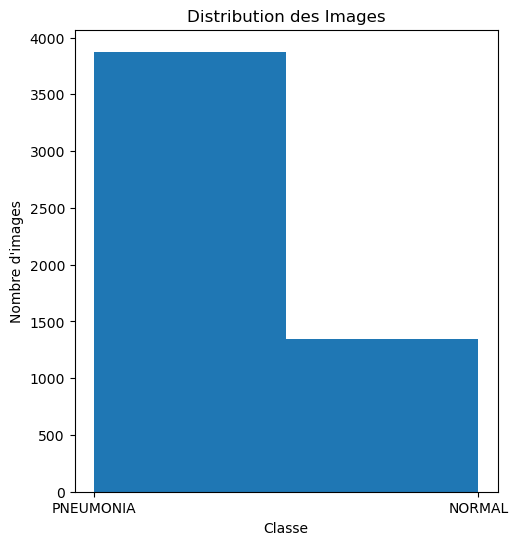

In [18]:
# Visualisation des Données
def plot_data_distribution(data_dir1, data_dir2):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Distribution des Images")
    plt.hist([os.path.basename(data_dir1)]*len(os.listdir(data_dir1)) + [os.path.basename(data_dir2)]*len(os.listdir(data_dir2)), bins=2)
    plt.xlabel('Classe')
    plt.ylabel('Nombre d\'images')
    plt.xticks([0, 1], ['PNEUMONIA', 'NORMAL'])
    plt.show()

plot_data_distribution(data_dir1, data_dir2)

In [20]:
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [22]:
# Validation Croisée K-Fold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
fold = 1
history_list = []

for train_index, val_index in kf.split(x):
    print(f"Fold {fold}/{n_splits}")
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    datagen = create_datagen()
    datagen.fit(x_train)

    model = build_model()
    print("Résumé du modèle :")
    print(model.summary())

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_val, y_val),
                        callbacks=[reduce_lr, early_stop])
    
    history_list.append(history)
    print("Fold terminé.")
    fold += 1

print("Validation croisée terminée.")

Fold 1/15


C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Résumé du modèle :


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20


C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 406ms/step - accuracy: 0.5481 - loss: 0.7711 - val_accuracy: 0.7857 - val_loss: 0.6719 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 411ms/step - accuracy: 0.5658 - loss: 0.6812 - val_accuracy: 0.6429 - val_loss: 0.5870 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 301ms/step - accuracy: 0.7095 - loss: 0.5941 - val_accuracy: 0.7143 - val_loss: 0.4762 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 340ms/step - accuracy: 0.7896 - loss: 0.4634 - val_accuracy: 0.7857 - val_loss: 0.3830 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - accuracy: 0.7951 - loss: 0.4588 - val_accuracy: 1.0000 - val_loss: 0.0480 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 271ms/step - accuracy: 0.8768 - loss: 0.2906 - val_accuracy: 0.9286 - val_loss: 0.1628 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - accuracy: 0.8948 - loss: 0.3011 - val_accura

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.6313 - loss: 0.9138 - val_accuracy: 0.3571 - val_loss: 0.7475 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 306ms/step - accuracy: 0.5449 - loss: 0.6787 - val_accuracy: 1.0000 - val_loss: 0.5783 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 296ms/step - accuracy: 0.7797 - loss: 0.5549 - val_accuracy: 1.0000 - val_loss: 0.2314 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 307ms/step - accuracy: 0.8480 - loss: 0.4408 - val_accuracy: 0.8571 - val_loss: 0.3296 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 328ms/step - accuracy: 0.8496 - loss: 0.4423 - val_accuracy: 1.0000 - val_loss: 0.1280 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 342ms/step - accuracy: 0.9238 - loss: 0.2218 - val_accuracy: 1.0000 - val_loss: 0.0172 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 317ms/step - accuracy: 0.8826 - loss: 0.3

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 378ms/step - accuracy: 0.4539 - loss: 1.0390 - val_accuracy: 0.5714 - val_loss: 0.6759 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 327ms/step - accuracy: 0.4575 - loss: 0.6934 - val_accuracy: 0.7857 - val_loss: 0.6680 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 289ms/step - accuracy: 0.5391 - loss: 0.6939 - val_accuracy: 0.6429 - val_loss: 0.6192 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 307ms/step - accuracy: 0.6172 - loss: 0.6330 - val_accuracy: 1.0000 - val_loss: 0.4598 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 305ms/step - accuracy: 0.8444 - loss: 0.5095 - val_accuracy: 1.0000 - val_loss: 0.2623 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 280ms/step - accuracy: 0.8257 - loss: 0.4113 - val_accuracy: 0.7143 - val_loss: 0.3603 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 289ms/step - accuracy: 0.8615 - loss: 0.4

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 343ms/step - accuracy: 0.4665 - loss: 0.8130 - val_accuracy: 0.5000 - val_loss: 0.7368 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - accuracy: 0.6069 - loss: 0.6591 - val_accuracy: 0.5000 - val_loss: 0.6244 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step - accuracy: 0.6037 - loss: 0.6478 - val_accuracy: 0.7857 - val_loss: 0.4375 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 316ms/step - accuracy: 0.7922 - loss: 0.4831 - val_accuracy: 0.7857 - val_loss: 0.4430 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 327ms/step - accuracy: 0.8004 - loss: 0.3961 - val_accuracy: 0.9286 - val_loss: 0.2666 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 296ms/step - accuracy: 0.9010 - loss: 0.2929 - val_accuracy: 0.9286 - val_loss: 0.2741 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 335ms/step - accuracy: 0.9002 - loss: 0.2

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 381ms/step - accuracy: 0.5645 - loss: 0.7056 - val_accuracy: 0.5000 - val_loss: 0.6695 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - accuracy: 0.6912 - loss: 0.6333 - val_accuracy: 0.7857 - val_loss: 0.4374 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 300ms/step - accuracy: 0.7907 - loss: 0.4518 - val_accuracy: 0.7143 - val_loss: 0.5186 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.8281 - loss: 0.4579 - val_accuracy: 0.9286 - val_loss: 0.2705 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 350ms/step - accuracy: 0.8559 - loss: 0.2787 - val_accuracy: 0.9286 - val_loss: 0.2007 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 462ms/step - accuracy: 0.9392 - loss: 0.2208 - val_accuracy: 0.9286 - val_loss: 0.2207 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 328ms/step - accuracy: 0.8857 - loss: 0.2

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.4485 - loss: 0.8212 - val_accuracy: 0.5385 - val_loss: 0.6812 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 287ms/step - accuracy: 0.5096 - loss: 0.7136 - val_accuracy: 0.7692 - val_loss: 0.6423 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 273ms/step - accuracy: 0.5373 - loss: 0.6742 - val_accuracy: 0.8462 - val_loss: 0.5149 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 282ms/step - accuracy: 0.6565 - loss: 0.5940 - val_accuracy: 1.0000 - val_loss: 0.2161 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 296ms/step - accuracy: 0.8468 - loss: 0.3814 - val_accuracy: 1.0000 - val_loss: 0.0334 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 387ms/step - accuracy: 0.9150 - loss: 0.2242 - val_accuracy: 1.0000 - val_loss: 0.0722 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 343ms/step - accuracy: 0.8936 - loss: 0.2

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 466ms/step - accuracy: 0.4621 - loss: 1.0639 - val_accuracy: 0.4615 - val_loss: 0.6922 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 392ms/step - accuracy: 0.4905 - loss: 0.6990 - val_accuracy: 0.6923 - val_loss: 0.6848 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - accuracy: 0.5566 - loss: 0.6930 - val_accuracy: 0.5385 - val_loss: 0.6552 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 387ms/step - accuracy: 0.5956 - loss: 0.6598 - val_accuracy: 0.9231 - val_loss: 0.4549 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 328ms/step - accuracy: 0.7530 - loss: 0.5441 - val_accuracy: 0.9231 - val_loss: 0.3313 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 443ms/step - accuracy: 0.8759 - loss: 0.3733 - val_accuracy: 0.8462 - val_loss: 0.4699 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.8971 - loss: 0.2

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 385ms/step - accuracy: 0.4505 - loss: 0.8102 - val_accuracy: 0.5385 - val_loss: 0.6843 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 337ms/step - accuracy: 0.5343 - loss: 0.6902 - val_accuracy: 0.5385 - val_loss: 0.6774 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 306ms/step - accuracy: 0.6302 - loss: 0.6600 - val_accuracy: 0.8462 - val_loss: 0.5288 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 296ms/step - accuracy: 0.8127 - loss: 0.4445 - val_accuracy: 0.6923 - val_loss: 0.7206 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 338ms/step - accuracy: 0.7879 - loss: 0.5157 - val_accuracy: 0.8462 - val_loss: 0.5457 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 288ms/step - accuracy: 0.8533 - loss: 0.2965 - val_accuracy: 0.6923 - val_loss: 0.4150 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.9089 - loss: 0.2

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 410ms/step - accuracy: 0.5556 - loss: 0.7470 - val_accuracy: 0.5385 - val_loss: 0.6682 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.6318 - loss: 0.6786 - val_accuracy: 0.5385 - val_loss: 0.6258 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 293ms/step - accuracy: 0.6401 - loss: 0.6291 - val_accuracy: 1.0000 - val_loss: 0.4861 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 296ms/step - accuracy: 0.7193 - loss: 0.5839 - val_accuracy: 0.9231 - val_loss: 0.3555 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 347ms/step - accuracy: 0.8277 - loss: 0.4158 - val_accuracy: 0.9231 - val_loss: 0.2222 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 321ms/step - accuracy: 0.8570 - loss: 0.3437 - val_accuracy: 1.0000 - val_loss: 0.1019 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 308ms/step - accuracy: 0.9200 - loss: 0.1

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5442 - loss: 0.8754 - val_accuracy: 0.4615 - val_loss: 0.6881 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.5999 - loss: 0.6914 - val_accuracy: 0.6154 - val_loss: 0.6862 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 305ms/step - accuracy: 0.6055 - loss: 0.6745 - val_accuracy: 0.4615 - val_loss: 0.7319 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 321ms/step - accuracy: 0.6710 - loss: 0.5900 - val_accuracy: 0.6923 - val_loss: 0.9086 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - accuracy: 0.7471 - loss: 0.4782 - val_accuracy: 0.7692 - val_loss: 0.3874 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 311ms/step - accuracy: 0.8550 - loss: 0.3242 - val_accuracy: 0.7692 - val_loss: 0.6443 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step - accuracy: 0.8757 - loss: 0.2882

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 447ms/step - accuracy: 0.5262 - loss: 0.8371 - val_accuracy: 0.6154 - val_loss: 0.6740 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 344ms/step - accuracy: 0.6600 - loss: 0.6440 - val_accuracy: 0.4615 - val_loss: 0.7225 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - accuracy: 0.7090 - loss: 0.5875 - val_accuracy: 0.6923 - val_loss: 0.5799 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - accuracy: 0.8526 - loss: 0.3633 - val_accuracy: 0.7692 - val_loss: 0.5461 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 293ms/step - accuracy: 0.9095 - loss: 0.2902 - val_accuracy: 0.6923 - val_loss: 0.4212 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 294ms/step - accuracy: 0.8994 - loss: 0.2823 - val_accuracy: 0.7692 - val_loss: 0.4975 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 331ms/step - accuracy: 0.8671 - loss: 0.2

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 360ms/step - accuracy: 0.5586 - loss: 0.8624 - val_accuracy: 0.3846 - val_loss: 0.7191 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 305ms/step - accuracy: 0.5846 - loss: 0.6723 - val_accuracy: 0.9231 - val_loss: 0.6470 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 313ms/step - accuracy: 0.7021 - loss: 0.6488 - val_accuracy: 0.9231 - val_loss: 0.5362 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 336ms/step - accuracy: 0.7786 - loss: 0.5512 - val_accuracy: 0.6923 - val_loss: 0.7774 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step - accuracy: 0.7648 - loss: 0.5462 - val_accuracy: 0.9231 - val_loss: 0.3100 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.8532 - loss: 0.3701 - val_accuracy: 0.9231 - val_loss: 0.2756 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 294ms/step - accuracy: 0.7884 - loss: 0.4

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.5808 - loss: 0.7242 - val_accuracy: 0.3846 - val_loss: 0.6902 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 350ms/step - accuracy: 0.6198 - loss: 0.6382 - val_accuracy: 0.9231 - val_loss: 0.4152 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 300ms/step - accuracy: 0.7985 - loss: 0.3967 - val_accuracy: 0.9231 - val_loss: 0.2886 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 330ms/step - accuracy: 0.8786 - loss: 0.3847 - val_accuracy: 0.9231 - val_loss: 0.2204 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 337ms/step - accuracy: 0.8808 - loss: 0.2121 - val_accuracy: 0.9231 - val_loss: 0.2059 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 273ms/step - accuracy: 0.9066 - loss: 0.2029 - val_accuracy: 0.9231 - val_loss: 0.2773 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 276ms/step - accuracy: 0.8878 - loss: 0.2

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 361ms/step - accuracy: 0.4725 - loss: 0.9131 - val_accuracy: 0.6923 - val_loss: 0.6576 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 299ms/step - accuracy: 0.4712 - loss: 0.7221 - val_accuracy: 0.6923 - val_loss: 0.6877 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 291ms/step - accuracy: 0.5210 - loss: 0.6882 - val_accuracy: 0.6923 - val_loss: 0.6447 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.6610 - loss: 0.6673 - val_accuracy: 0.6923 - val_loss: 0.6115 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 288ms/step - accuracy: 0.7903 - loss: 0.5011 - val_accuracy: 0.8462 - val_loss: 0.3684 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step - accuracy: 0.8804 - loss: 0.3605 - val_accuracy: 0.8462 - val_loss: 0.3513 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 278ms/step - accuracy: 0.8731 - loss: 0.2

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 352ms/step - accuracy: 0.5023 - loss: 0.7353 - val_accuracy: 1.0000 - val_loss: 0.6621 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - accuracy: 0.6629 - loss: 0.6689 - val_accuracy: 0.9231 - val_loss: 0.5479 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step - accuracy: 0.8024 - loss: 0.5435 - val_accuracy: 0.6154 - val_loss: 0.5875 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 291ms/step - accuracy: 0.7133 - loss: 0.4933 - val_accuracy: 0.7692 - val_loss: 0.3618 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - accuracy: 0.8956 - loss: 0.2957 - val_accuracy: 0.7692 - val_loss: 0.2696 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 288ms/step - accuracy: 0.8957 - loss: 0.3061 - val_accuracy: 0.9231 - val_loss: 0.3262 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 293ms/step - accuracy: 0.8878 - loss: 0.3

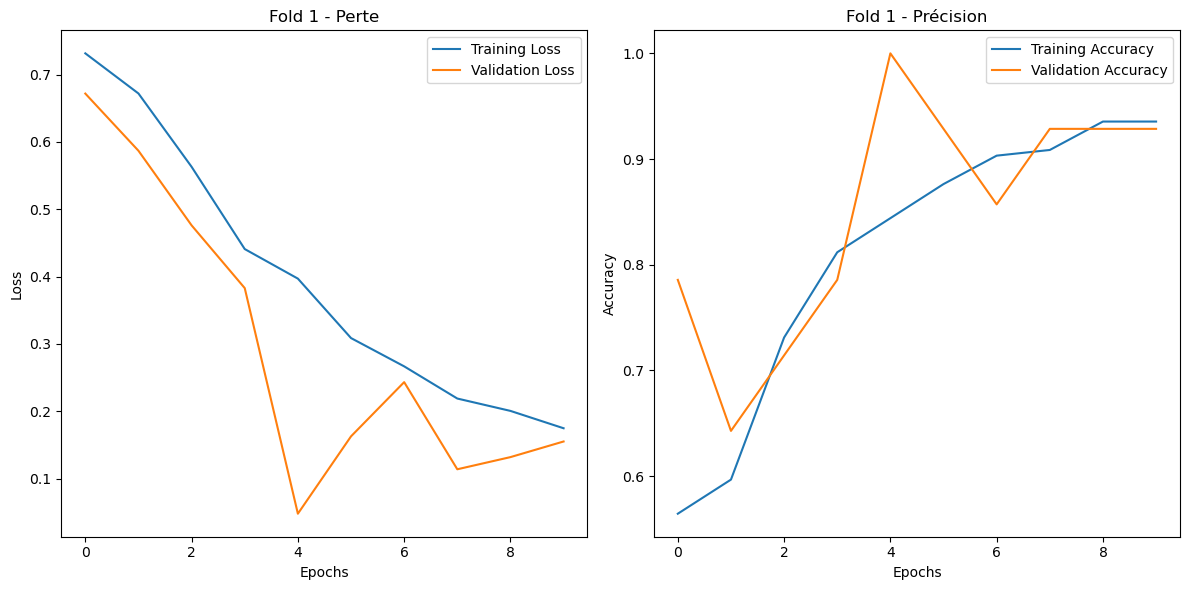

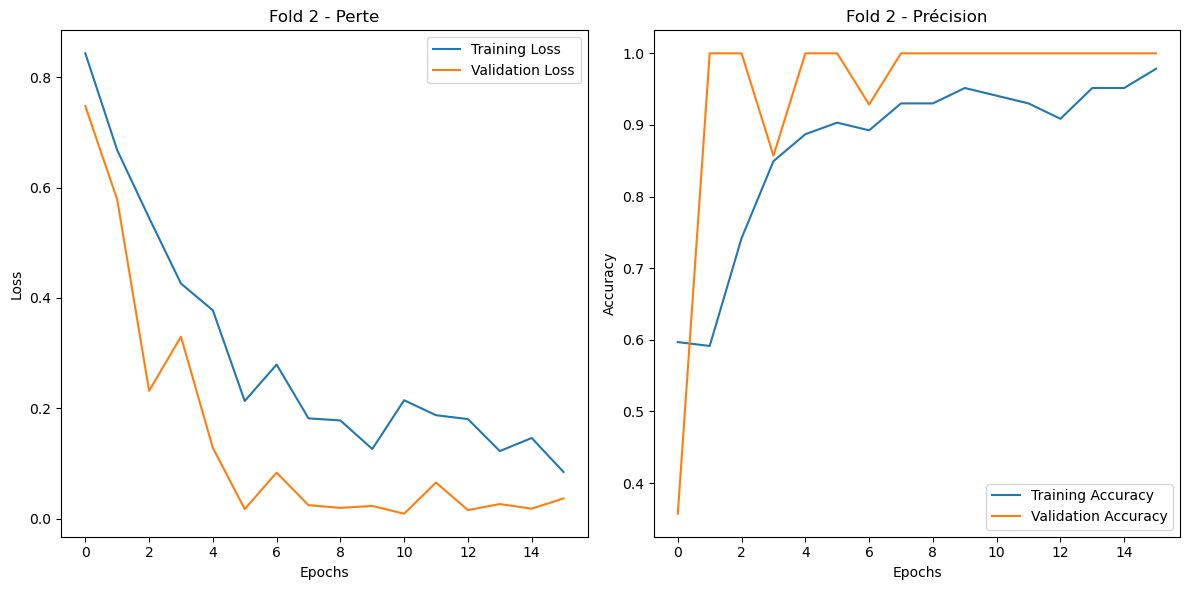

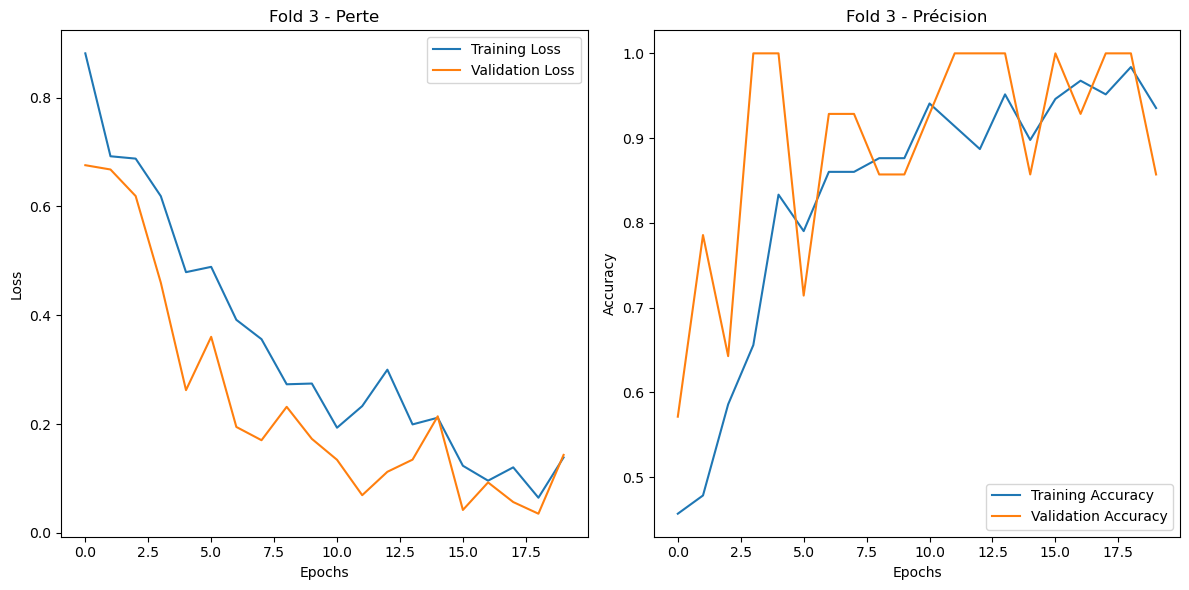

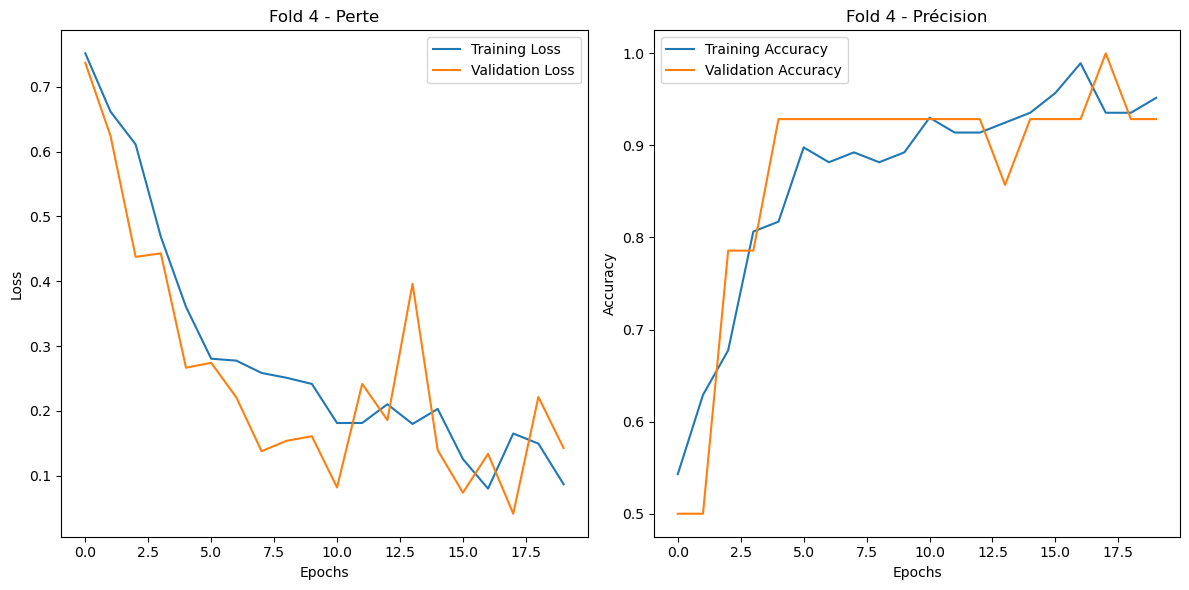

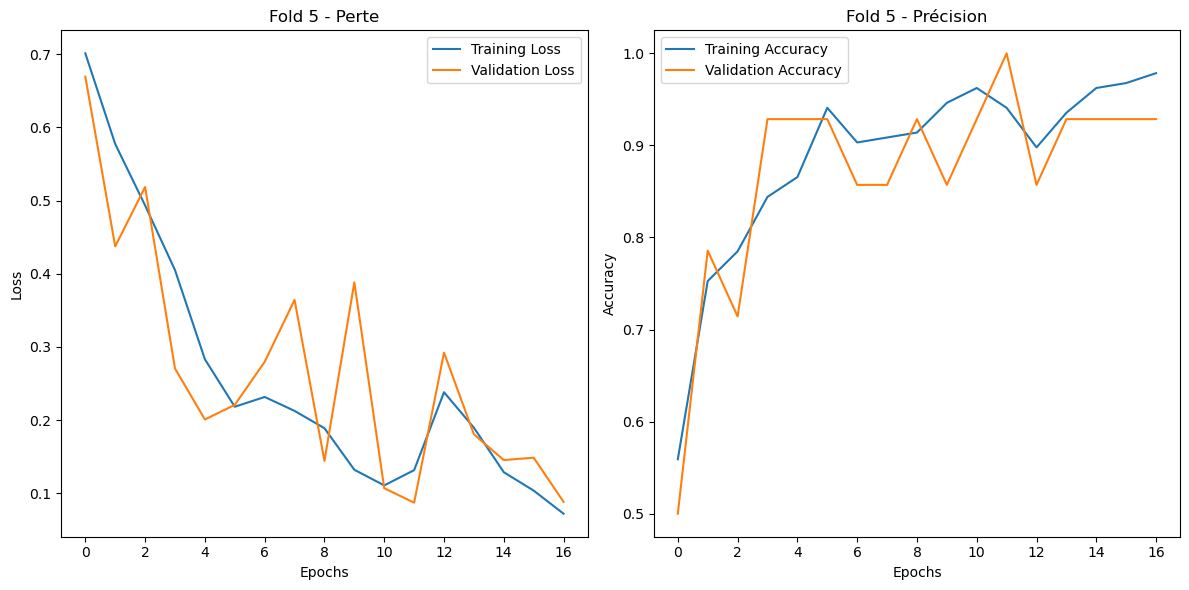

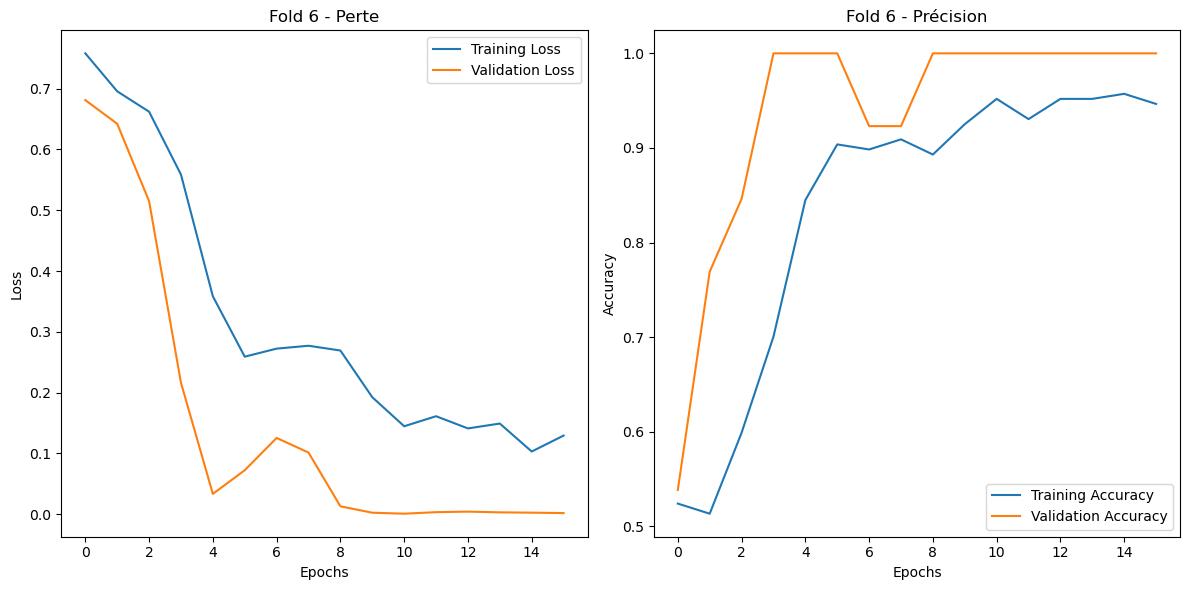

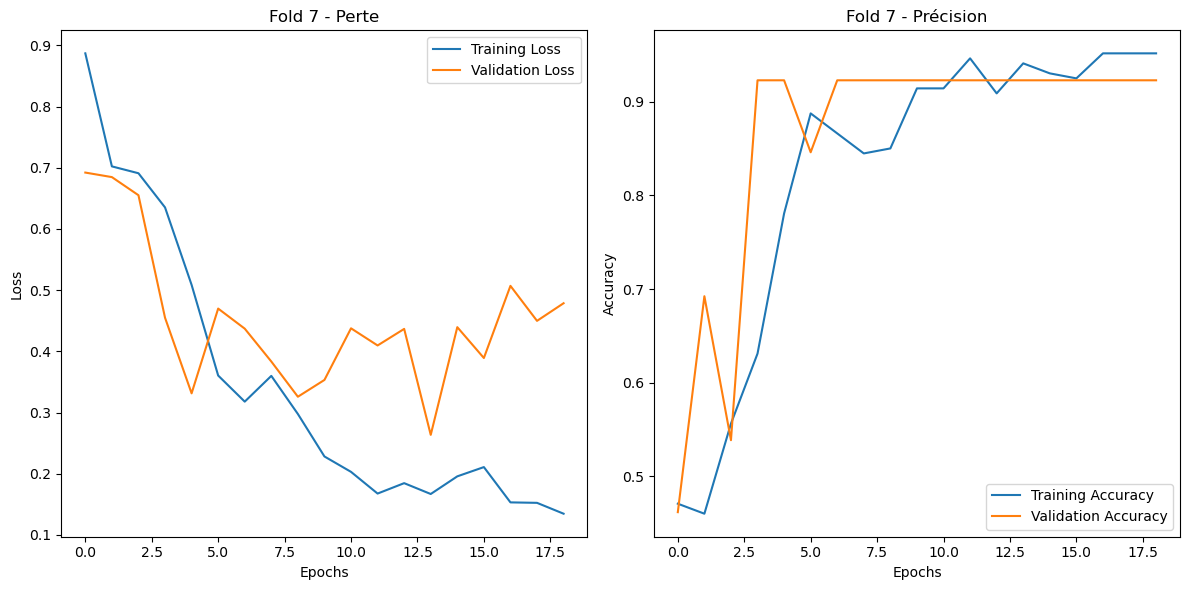

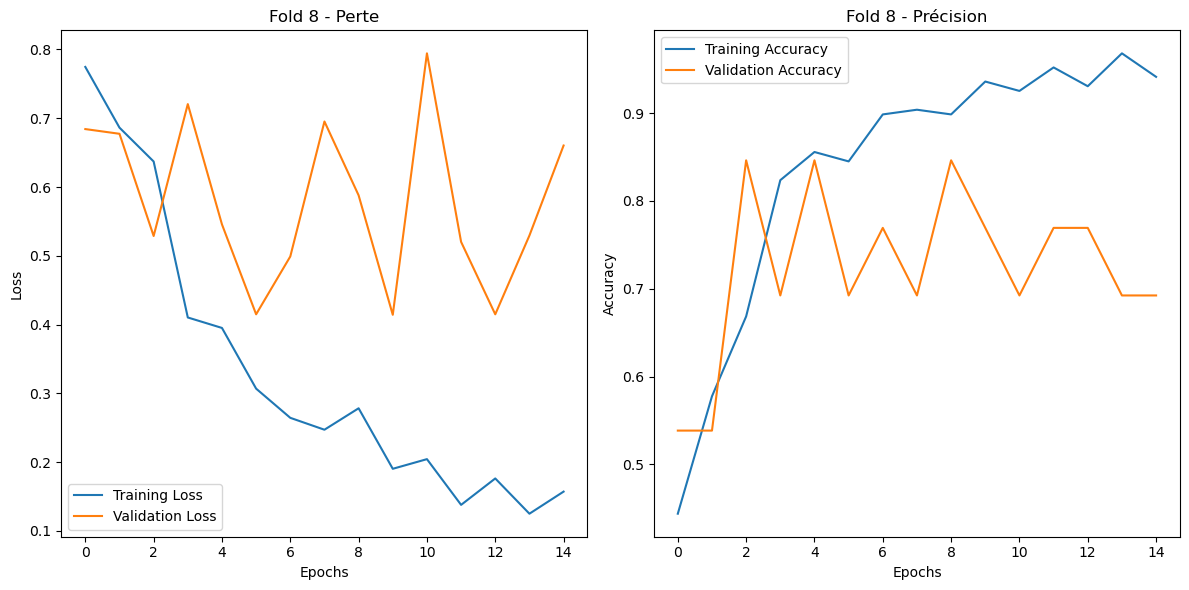

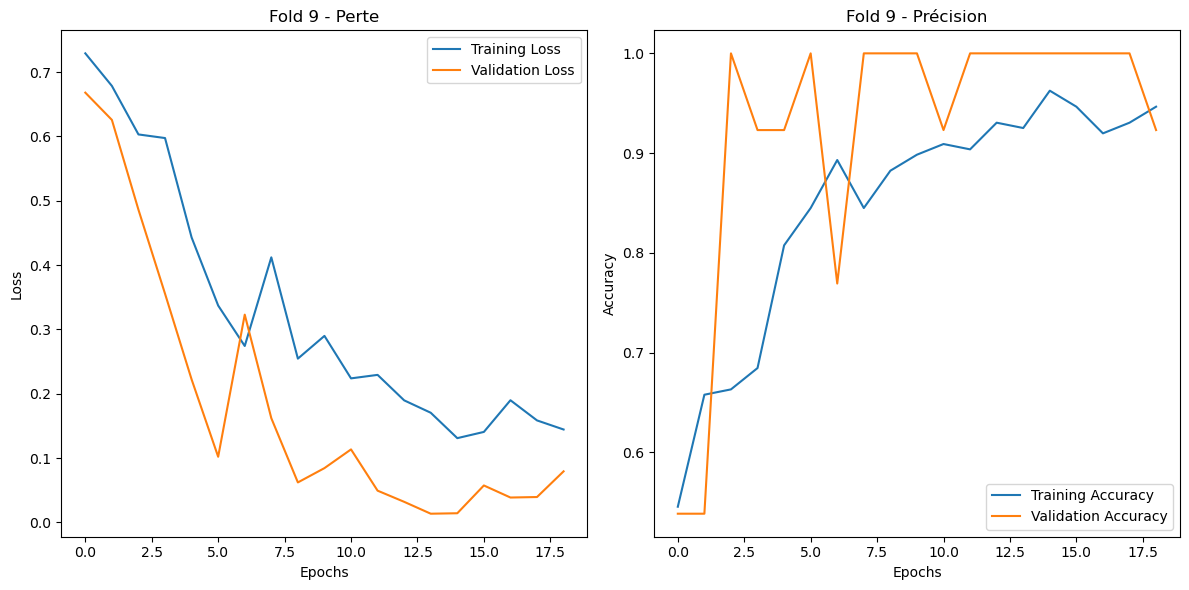

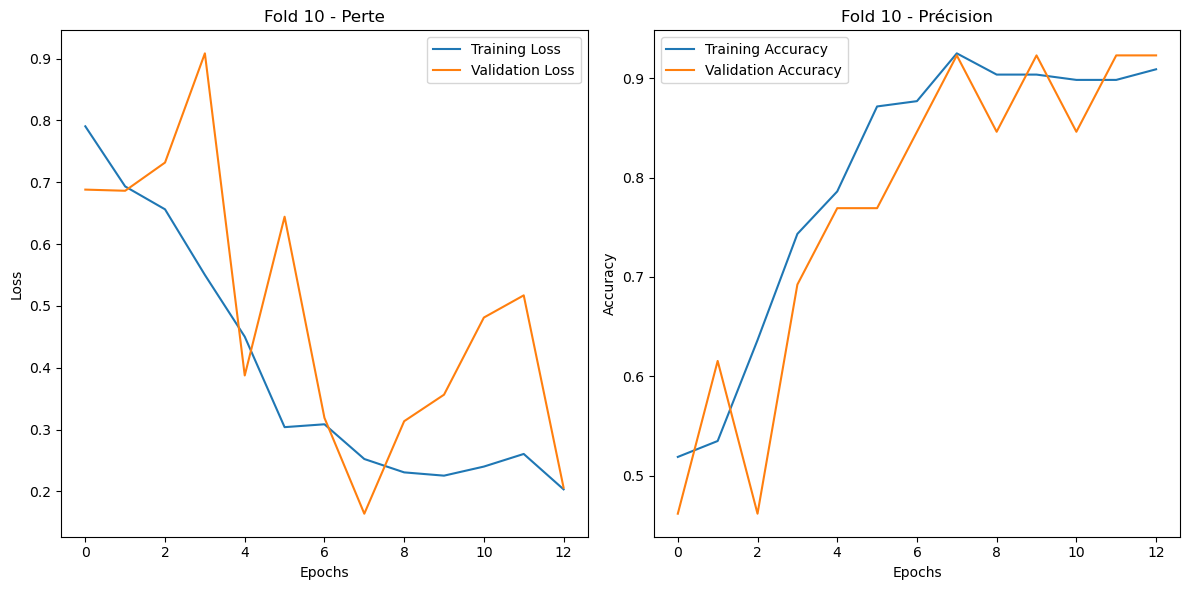

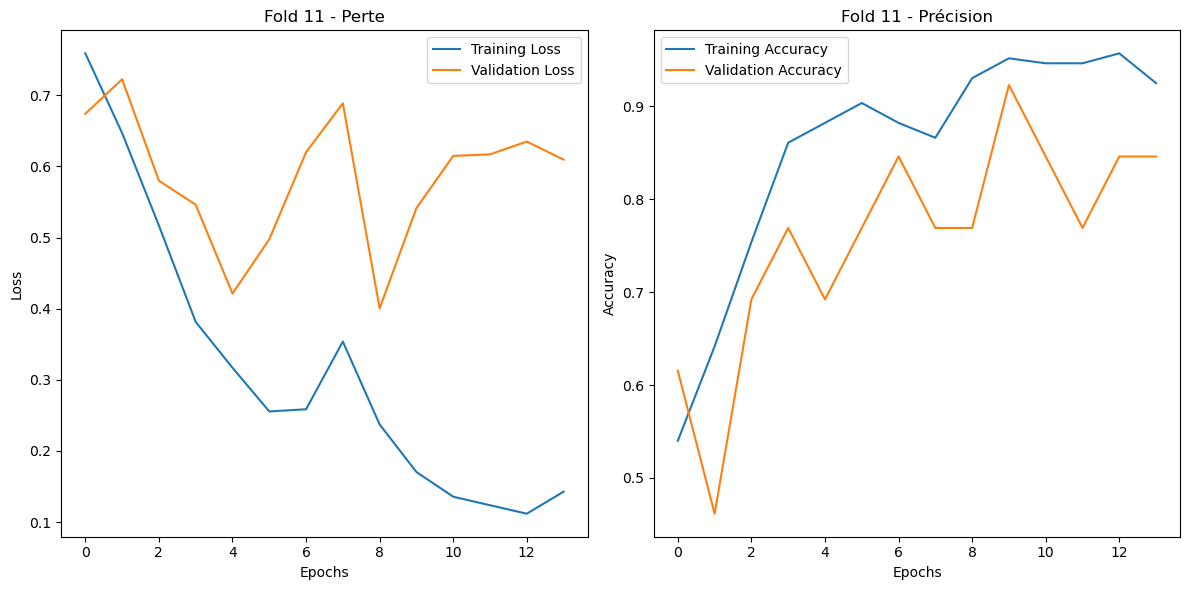

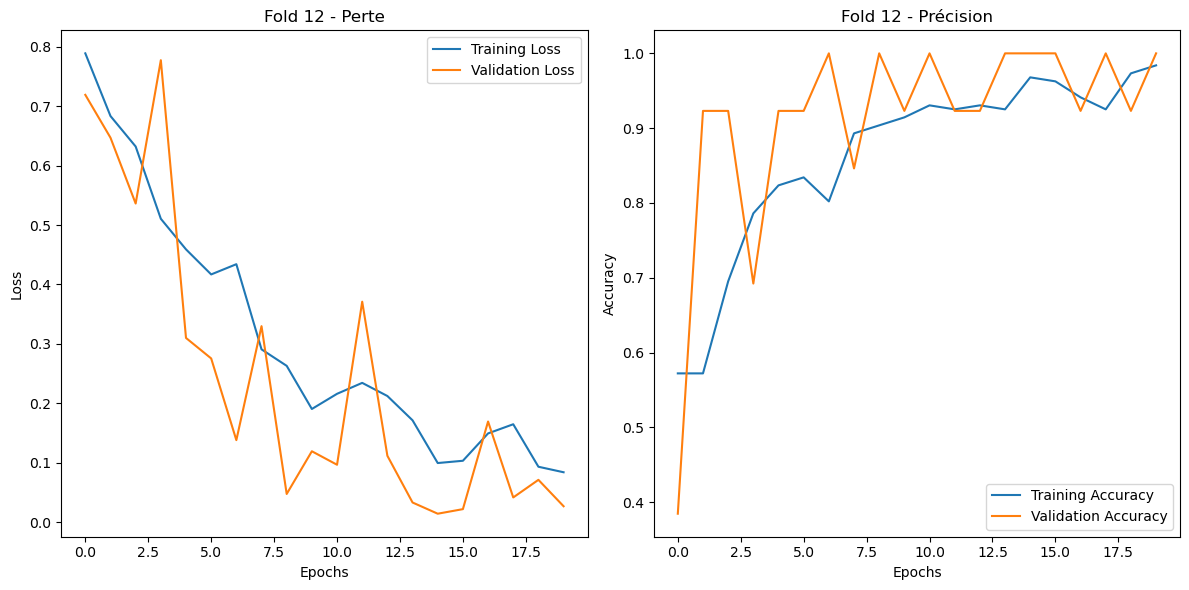

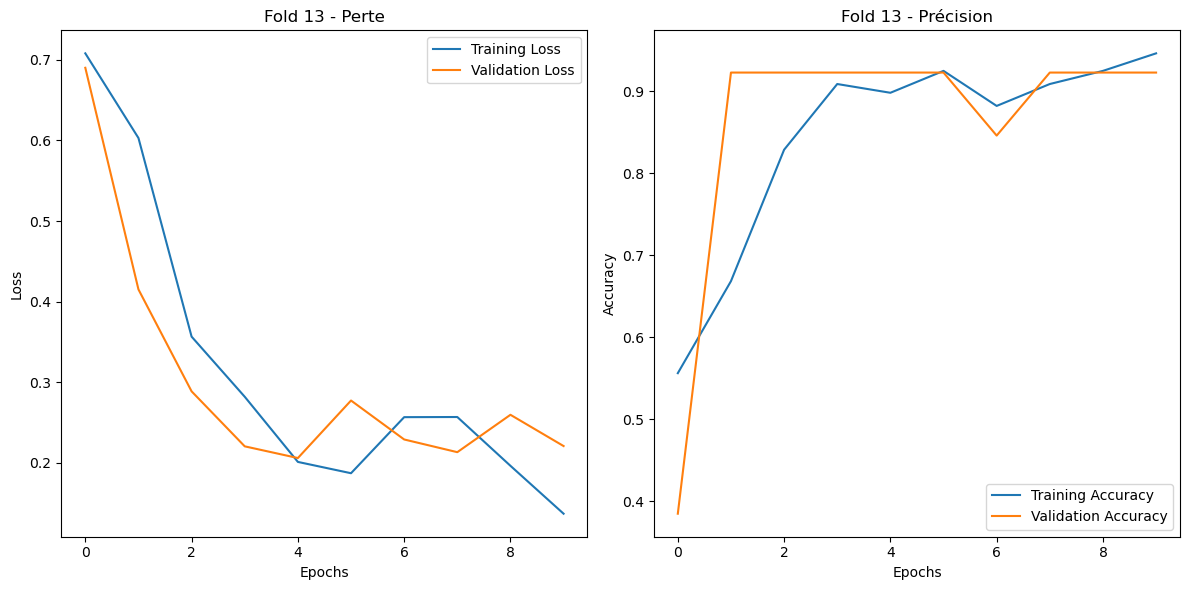

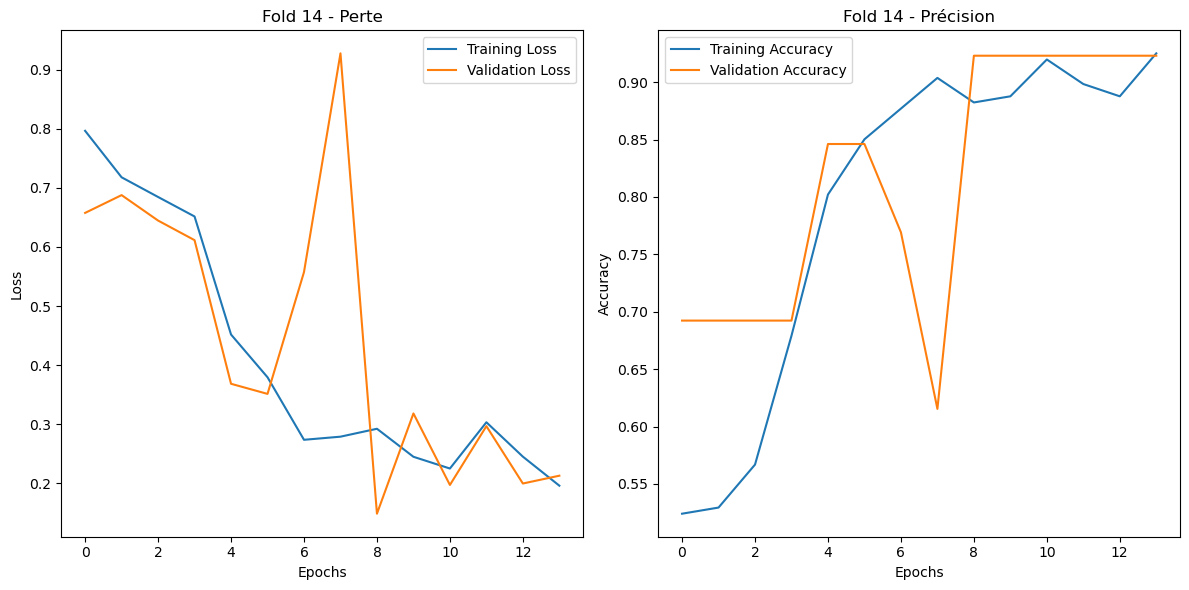

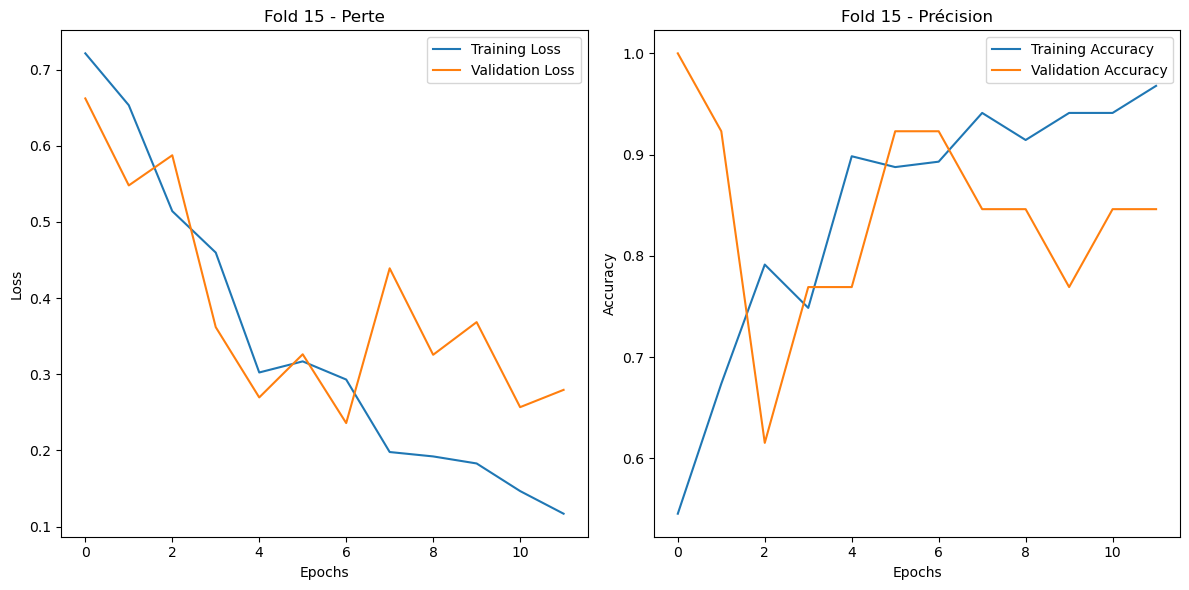

In [24]:
# Évaluation du Modèle
def plot_learning_curves(history_list):
    for fold, history in enumerate(history_list, start=1):
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Fold {fold} - Perte')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f'Fold {fold} - Précision')
        plt.legend()

        plt.tight_layout()
        plt.show()

plot_learning_curves(history_list)

Évaluation du modèle...
Évaluation pour Fold 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


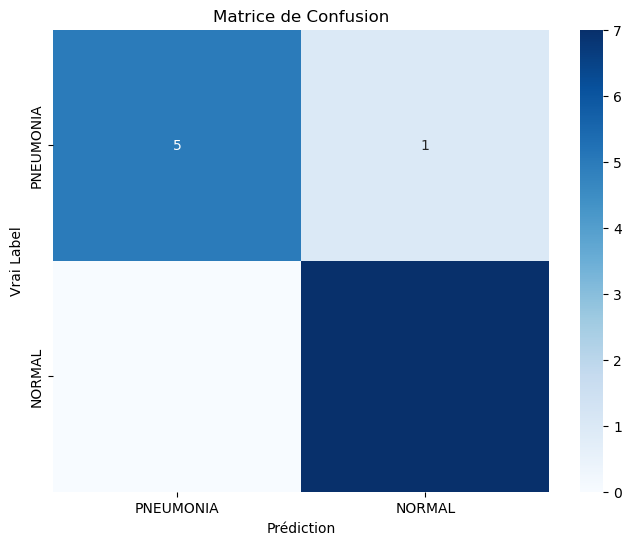

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.88      1.00      0.93         7

    accuracy                           0.92        13
   macro avg       0.94      0.92      0.92        13
weighted avg       0.93      0.92      0.92        13

Évaluation pour Fold 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


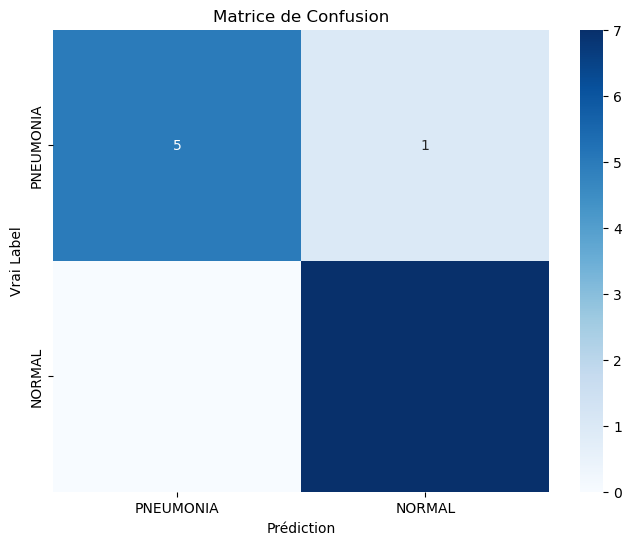

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.88      1.00      0.93         7

    accuracy                           0.92        13
   macro avg       0.94      0.92      0.92        13
weighted avg       0.93      0.92      0.92        13

Évaluation pour Fold 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


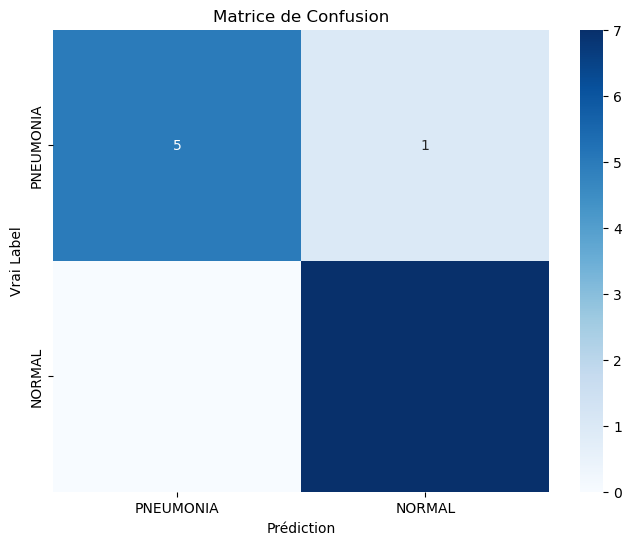

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.88      1.00      0.93         7

    accuracy                           0.92        13
   macro avg       0.94      0.92      0.92        13
weighted avg       0.93      0.92      0.92        13

Évaluation pour Fold 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


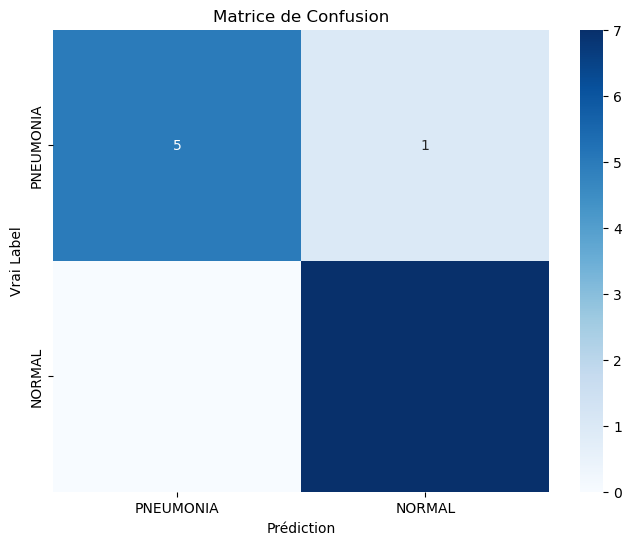

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.88      1.00      0.93         7

    accuracy                           0.92        13
   macro avg       0.94      0.92      0.92        13
weighted avg       0.93      0.92      0.92        13

Évaluation pour Fold 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


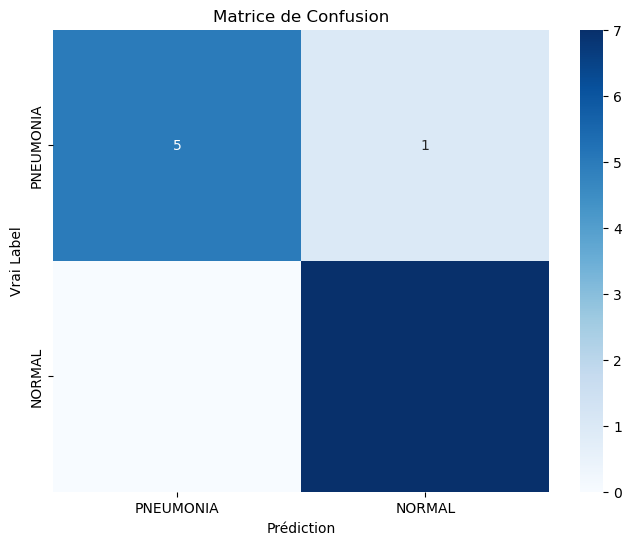

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.88      1.00      0.93         7

    accuracy                           0.92        13
   macro avg       0.94      0.92      0.92        13
weighted avg       0.93      0.92      0.92        13

Évaluation pour Fold 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


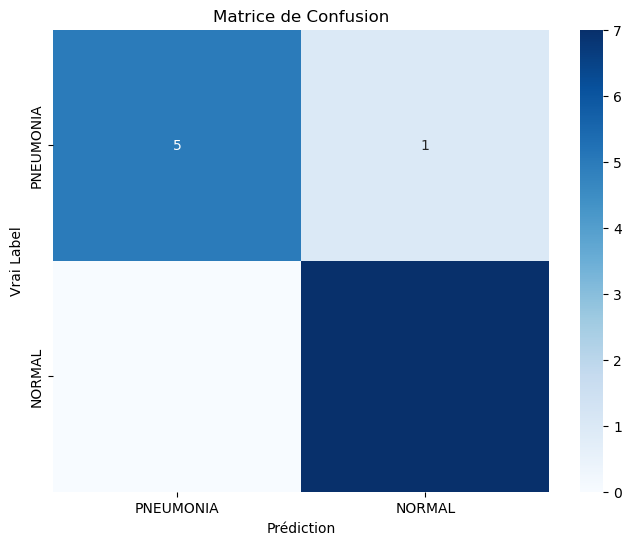

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.88      1.00      0.93         7

    accuracy                           0.92        13
   macro avg       0.94      0.92      0.92        13
weighted avg       0.93      0.92      0.92        13

Évaluation pour Fold 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


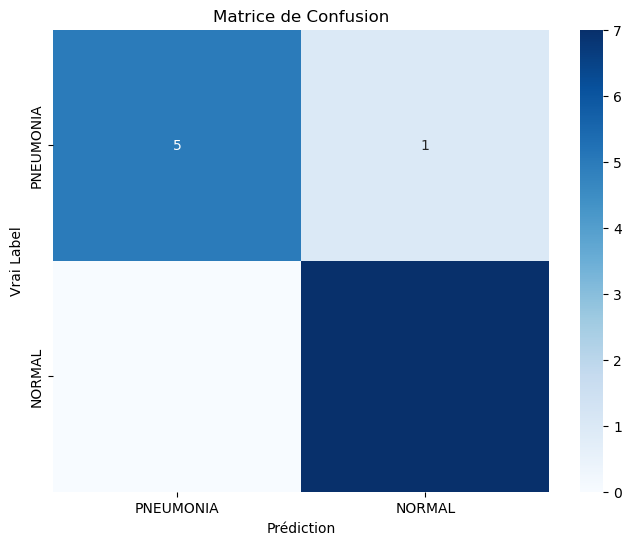

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.88      1.00      0.93         7

    accuracy                           0.92        13
   macro avg       0.94      0.92      0.92        13
weighted avg       0.93      0.92      0.92        13

Évaluation pour Fold 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


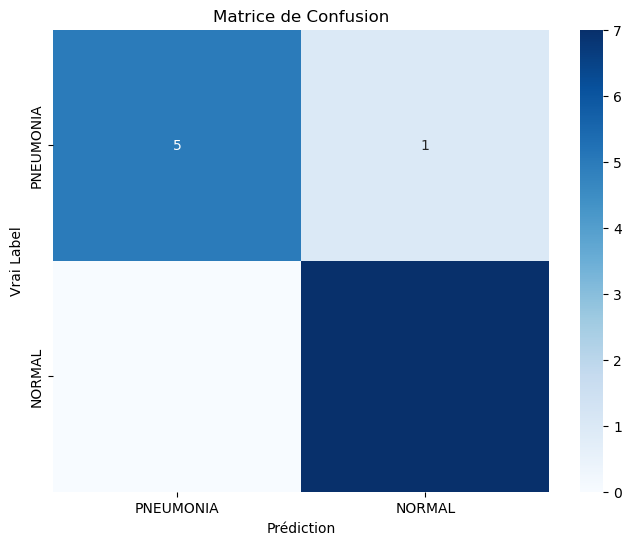

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.88      1.00      0.93         7

    accuracy                           0.92        13
   macro avg       0.94      0.92      0.92        13
weighted avg       0.93      0.92      0.92        13

Évaluation pour Fold 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


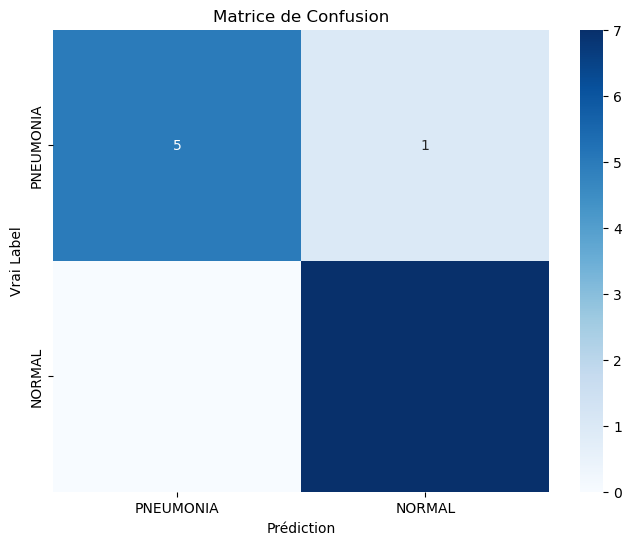

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.88      1.00      0.93         7

    accuracy                           0.92        13
   macro avg       0.94      0.92      0.92        13
weighted avg       0.93      0.92      0.92        13

Évaluation pour Fold 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


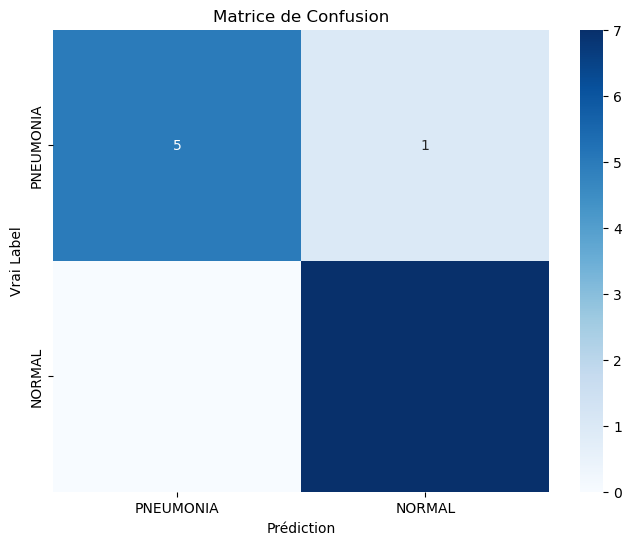

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.88      1.00      0.93         7

    accuracy                           0.92        13
   macro avg       0.94      0.92      0.92        13
weighted avg       0.93      0.92      0.92        13

Évaluation pour Fold 11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


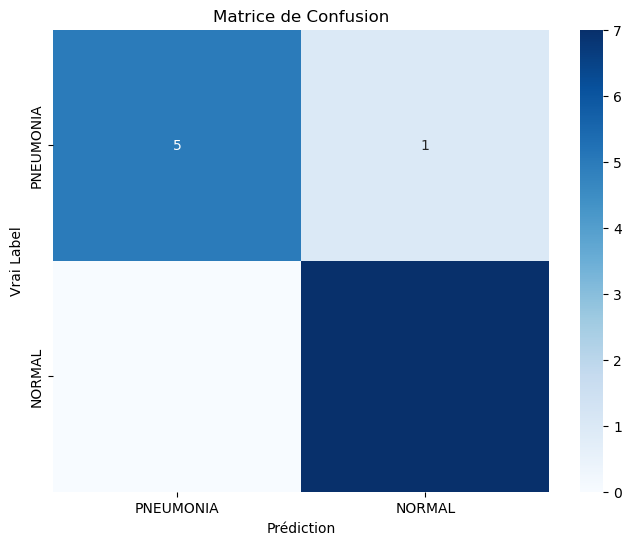

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.88      1.00      0.93         7

    accuracy                           0.92        13
   macro avg       0.94      0.92      0.92        13
weighted avg       0.93      0.92      0.92        13

Évaluation pour Fold 12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


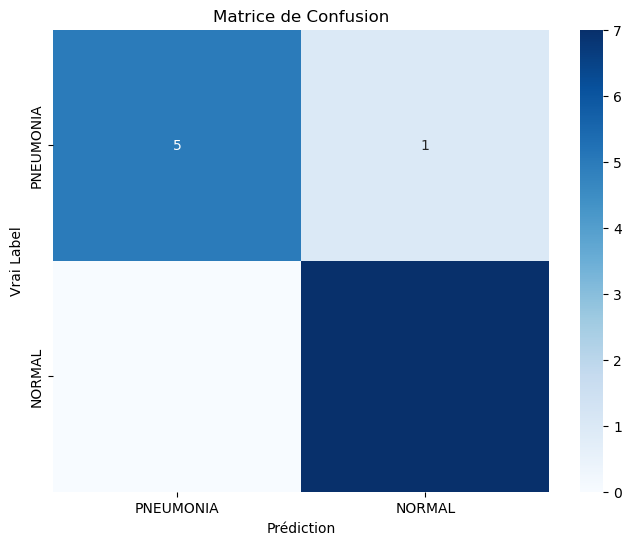

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.88      1.00      0.93         7

    accuracy                           0.92        13
   macro avg       0.94      0.92      0.92        13
weighted avg       0.93      0.92      0.92        13

Évaluation pour Fold 13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


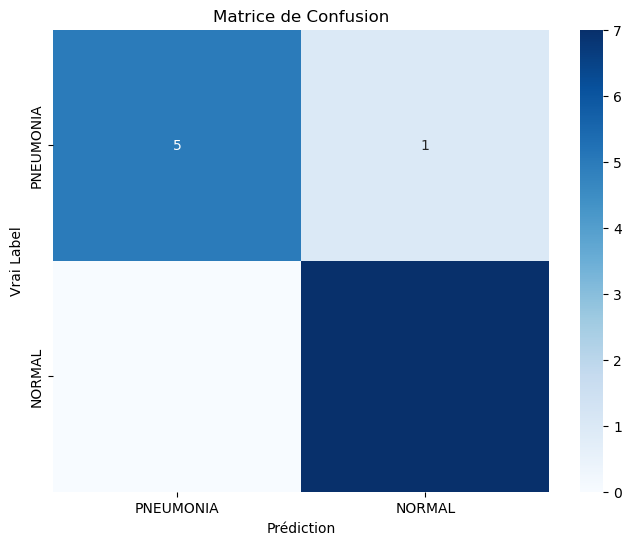

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.88      1.00      0.93         7

    accuracy                           0.92        13
   macro avg       0.94      0.92      0.92        13
weighted avg       0.93      0.92      0.92        13

Évaluation pour Fold 14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


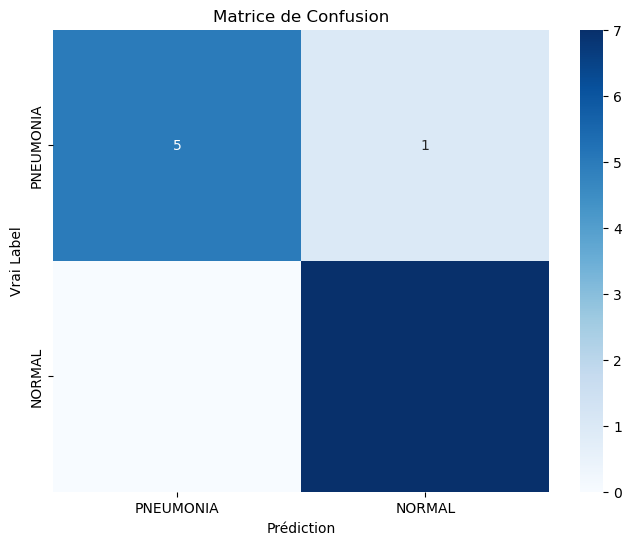

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.88      1.00      0.93         7

    accuracy                           0.92        13
   macro avg       0.94      0.92      0.92        13
weighted avg       0.93      0.92      0.92        13

Évaluation pour Fold 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


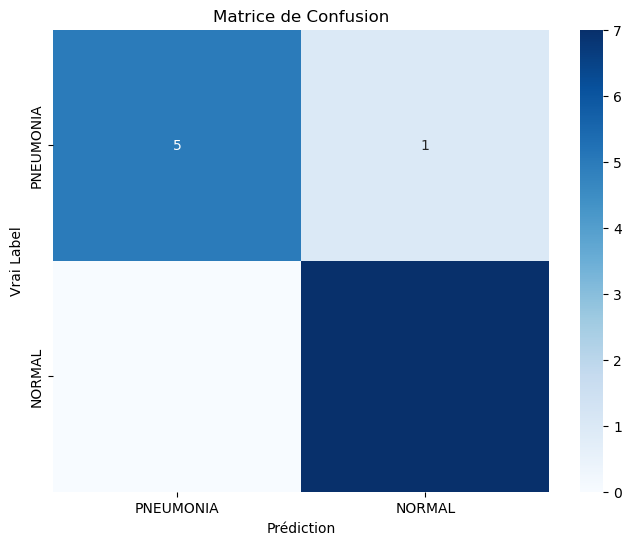

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.88      1.00      0.93         7

    accuracy                           0.92        13
   macro avg       0.94      0.92      0.92        13
weighted avg       0.93      0.92      0.92        13



In [26]:
def evaluate_and_plot_results(model, x_val, y_val):
    y_pred = (model.predict(x_val) > 0.5).astype("int32")
    cm = confusion_matrix(y_val, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['PNEUMONIA', 'NORMAL'], yticklabels=['PNEUMONIA', 'NORMAL'])
    plt.ylabel('Vrai Label')
    plt.xlabel('Prédiction')
    plt.title('Matrice de Confusion')
    plt.show()
    print(classification_report(y_val, y_pred))

# Prédictions et Analyse
print("Évaluation du modèle...")
for fold in range(n_splits):
    print(f"Évaluation pour Fold {fold + 1}")
    evaluate_and_plot_results(model, x_val, y_val)

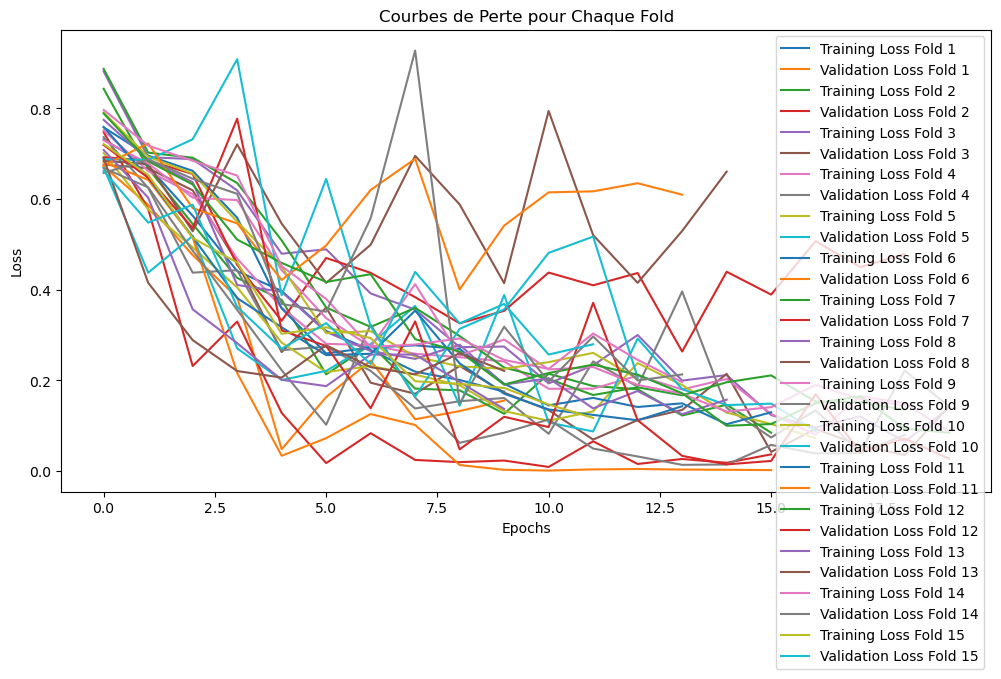

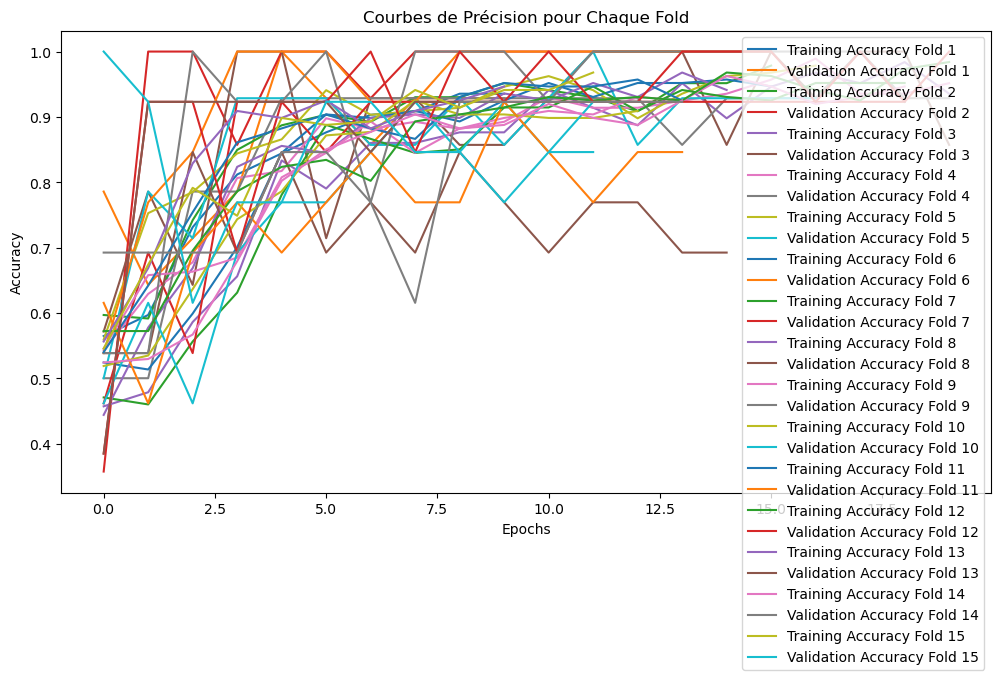

In [28]:
def plot_loss_curves(history_list):
    plt.figure(figsize=(12, 6))
    for fold, history in enumerate(history_list, start=1):
        plt.plot(history.history['loss'], label=f'Training Loss Fold {fold}')
        plt.plot(history.history['val_loss'], label=f'Validation Loss Fold {fold}')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Courbes de Perte pour Chaque Fold')
    plt.legend()
    plt.show()

plot_loss_curves(history_list)

def plot_accuracy_curves(history_list):
    plt.figure(figsize=(12, 6))
    for fold, history in enumerate(history_list, start=1):
        plt.plot(history.history['accuracy'], label=f'Training Accuracy Fold {fold}')
        plt.plot(history.history['val_accuracy'], label=f'Validation Accuracy Fold {fold}')
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Courbes de Précision pour Chaque Fold')
    plt.legend()
    plt.show()

plot_accuracy_curves(history_list)

Affichage des prédictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


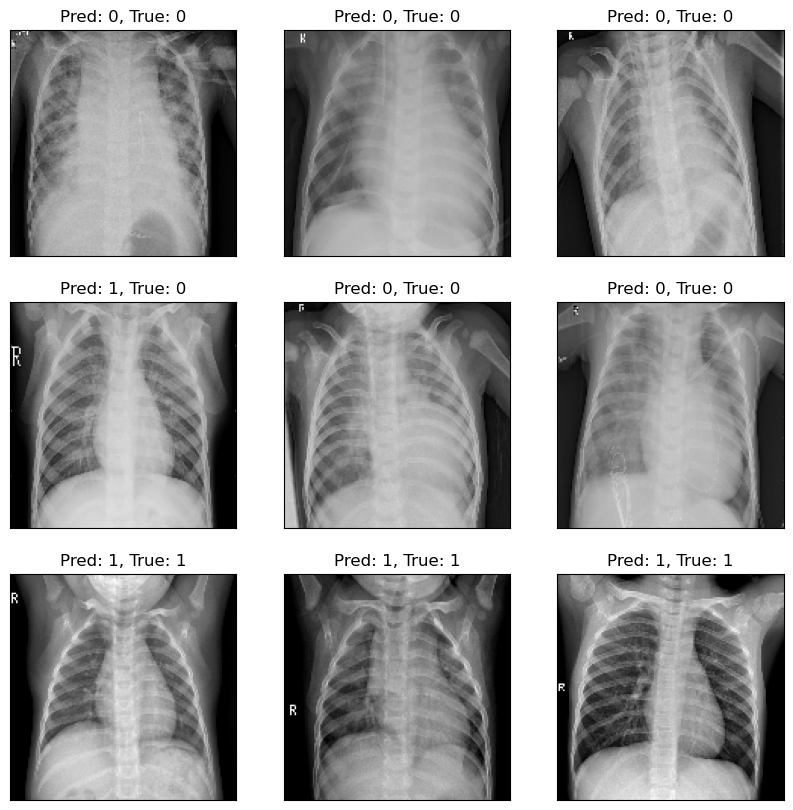

Affichage des prédictions terminé.


In [30]:
# Prédiction et Analyse
def display_predictions(model, x_val, y_val):
    print("Affichage des prédictions...")
    predictions = model.predict(x_val)
    predictions = (predictions > 0.5).astype("int32")
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(330 + 1 + i)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(x_val[i].reshape(img_size, img_size, 3))
        pred_label = predictions[i][0]
        true_label = y_val[i]
        plt.title(f"Pred: {pred_label}, True: {true_label}")
    plt.show()
    print("Affichage des prédictions terminé.")

# Exécuter la fonction display_predictions pour le dernier fold
display_predictions(model, x_val, y_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Nombre total de prédictions: 13
Valeur minimale des prédictions: 0.0086
Valeur maximale des prédictions: 0.9999
Moyenne des prédictions: 0.5680
Médiane des prédictions: 0.7978
Écart-type des prédictions: 0.4319
Bin 1: 0.01 - 0.06, Nombre d'images: 4
Bin 2: 0.06 - 0.11, Nombre d'images: 0
Bin 3: 0.11 - 0.16, Nombre d'images: 1
Bin 4: 0.16 - 0.21, Nombre d'images: 0
Bin 5: 0.21 - 0.26, Nombre d'images: 0
Bin 6: 0.26 - 0.31, Nombre d'images: 0
Bin 7: 0.31 - 0.36, Nombre d'images: 0
Bin 8: 0.36 - 0.41, Nombre d'images: 0
Bin 9: 0.41 - 0.45, Nombre d'images: 0
Bin 10: 0.45 - 0.50, Nombre d'images: 0
Bin 11: 0.50 - 0.55, Nombre d'images: 1
Bin 12: 0.55 - 0.60, Nombre d'images: 0
Bin 13: 0.60 - 0.65, Nombre d'images: 0
Bin 14: 0.65 - 0.70, Nombre d'images: 0
Bin 15: 0.70 - 0.75, Nombre d'images: 0
Bin 16: 0.75 - 0.80, Nombre d'images: 1
Bin 17: 0.80 - 0.85, Nombre d'images: 0
Bin 18: 0.85 - 0.90, Nombre d'images: 1
Bin 19: 0.90 - 0.95, Nombre d'images: 0

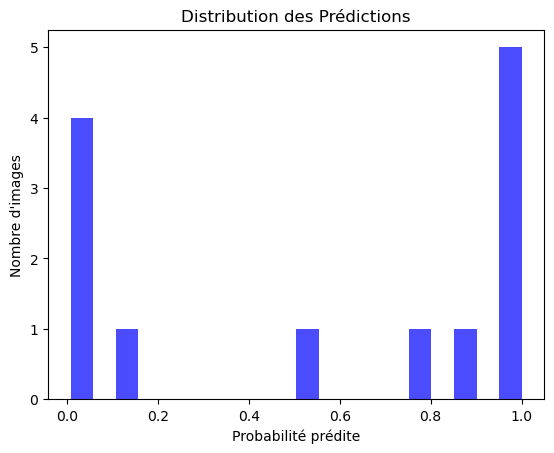

In [32]:
# Histogramme des prédictions
def plot_prediction_histogram(model, x_data):
    predictions = model.predict(x_data).flatten()
    print(f"Nombre total de prédictions: {len(predictions)}")
    print(f"Valeur minimale des prédictions: {predictions.min():.4f}")
    print(f"Valeur maximale des prédictions: {predictions.max():.4f}")
    print(f"Moyenne des prédictions: {predictions.mean():.4f}")
    print(f"Médiane des prédictions: {np.median(predictions):.4f}")
    print(f"Écart-type des prédictions: {predictions.std():.4f}")

    counts, bin_edges = np.histogram(predictions, bins=20)
    for i in range(len(counts)):
        print(f"Bin {i+1}: {bin_edges[i]:-.2f} - {bin_edges[i+1]:-.2f}, Nombre d'images: {counts[i]}")

    plt.hist(predictions, bins=20, color='blue', alpha=0.7)
    plt.xlabel('Probabilité prédite')
    plt.ylabel('Nombre d\'images')
    plt.title('Distribution des Prédictions')
    plt.show()

# Appel de la fonction pour afficher l'histogramme des prédictions
plot_prediction_histogram(model, x_val)

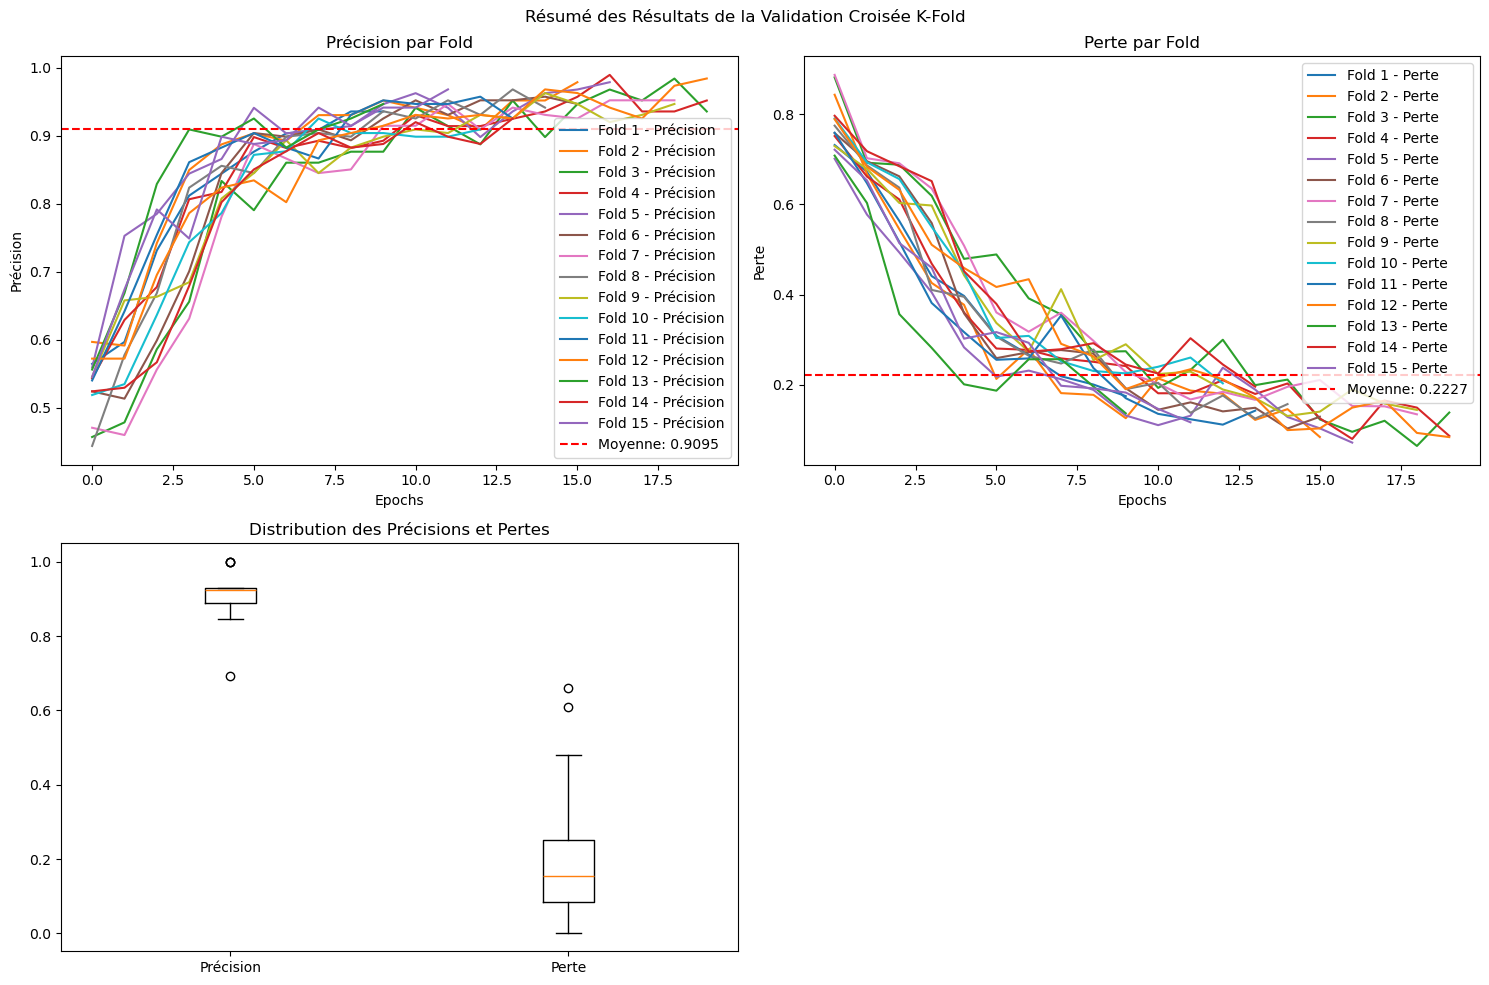

In [34]:
def plot_kfold_summary(history_list, num_folds):
    accuracy_per_fold = []
    loss_per_fold = []
    
    plt.figure(figsize=(15, 10))
    
    for i in range(num_folds):
        history = history_list[i]
        accuracy_per_fold.append(history.history['val_accuracy'][-1])
        loss_per_fold.append(history.history['val_loss'][-1])
        
        plt.subplot(2, 2, 1)
        plt.plot(history.history['accuracy'], label=f'Fold {i+1} - Précision')
        plt.title('Précision par Fold')
        plt.xlabel('Epochs')
        plt.ylabel('Précision')
        
        plt.subplot(2, 2, 2)
        plt.plot(history.history['loss'], label=f'Fold {i+1} - Perte')
        plt.title('Perte par Fold')
        plt.xlabel('Epochs')
        plt.ylabel('Perte')

    plt.subplot(2, 2, 1)
    plt.axhline(y=np.mean(accuracy_per_fold), color='r', linestyle='--', label=f'Moyenne: {np.mean(accuracy_per_fold):.4f}')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.axhline(y=np.mean(loss_per_fold), color='r', linestyle='--', label=f'Moyenne: {np.mean(loss_per_fold):.4f}')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.boxplot([accuracy_per_fold, loss_per_fold], labels=['Précision', 'Perte'])
    plt.title('Distribution des Précisions et Pertes')

    plt.suptitle('Résumé des Résultats de la Validation Croisée K-Fold')
    plt.tight_layout()
    plt.show()

plot_kfold_summary(history_list, n_splits)